In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

import sklearn as sk
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

Autosaving every 15 seconds


In [2]:
data = pd.read_csv('test_data.csv')

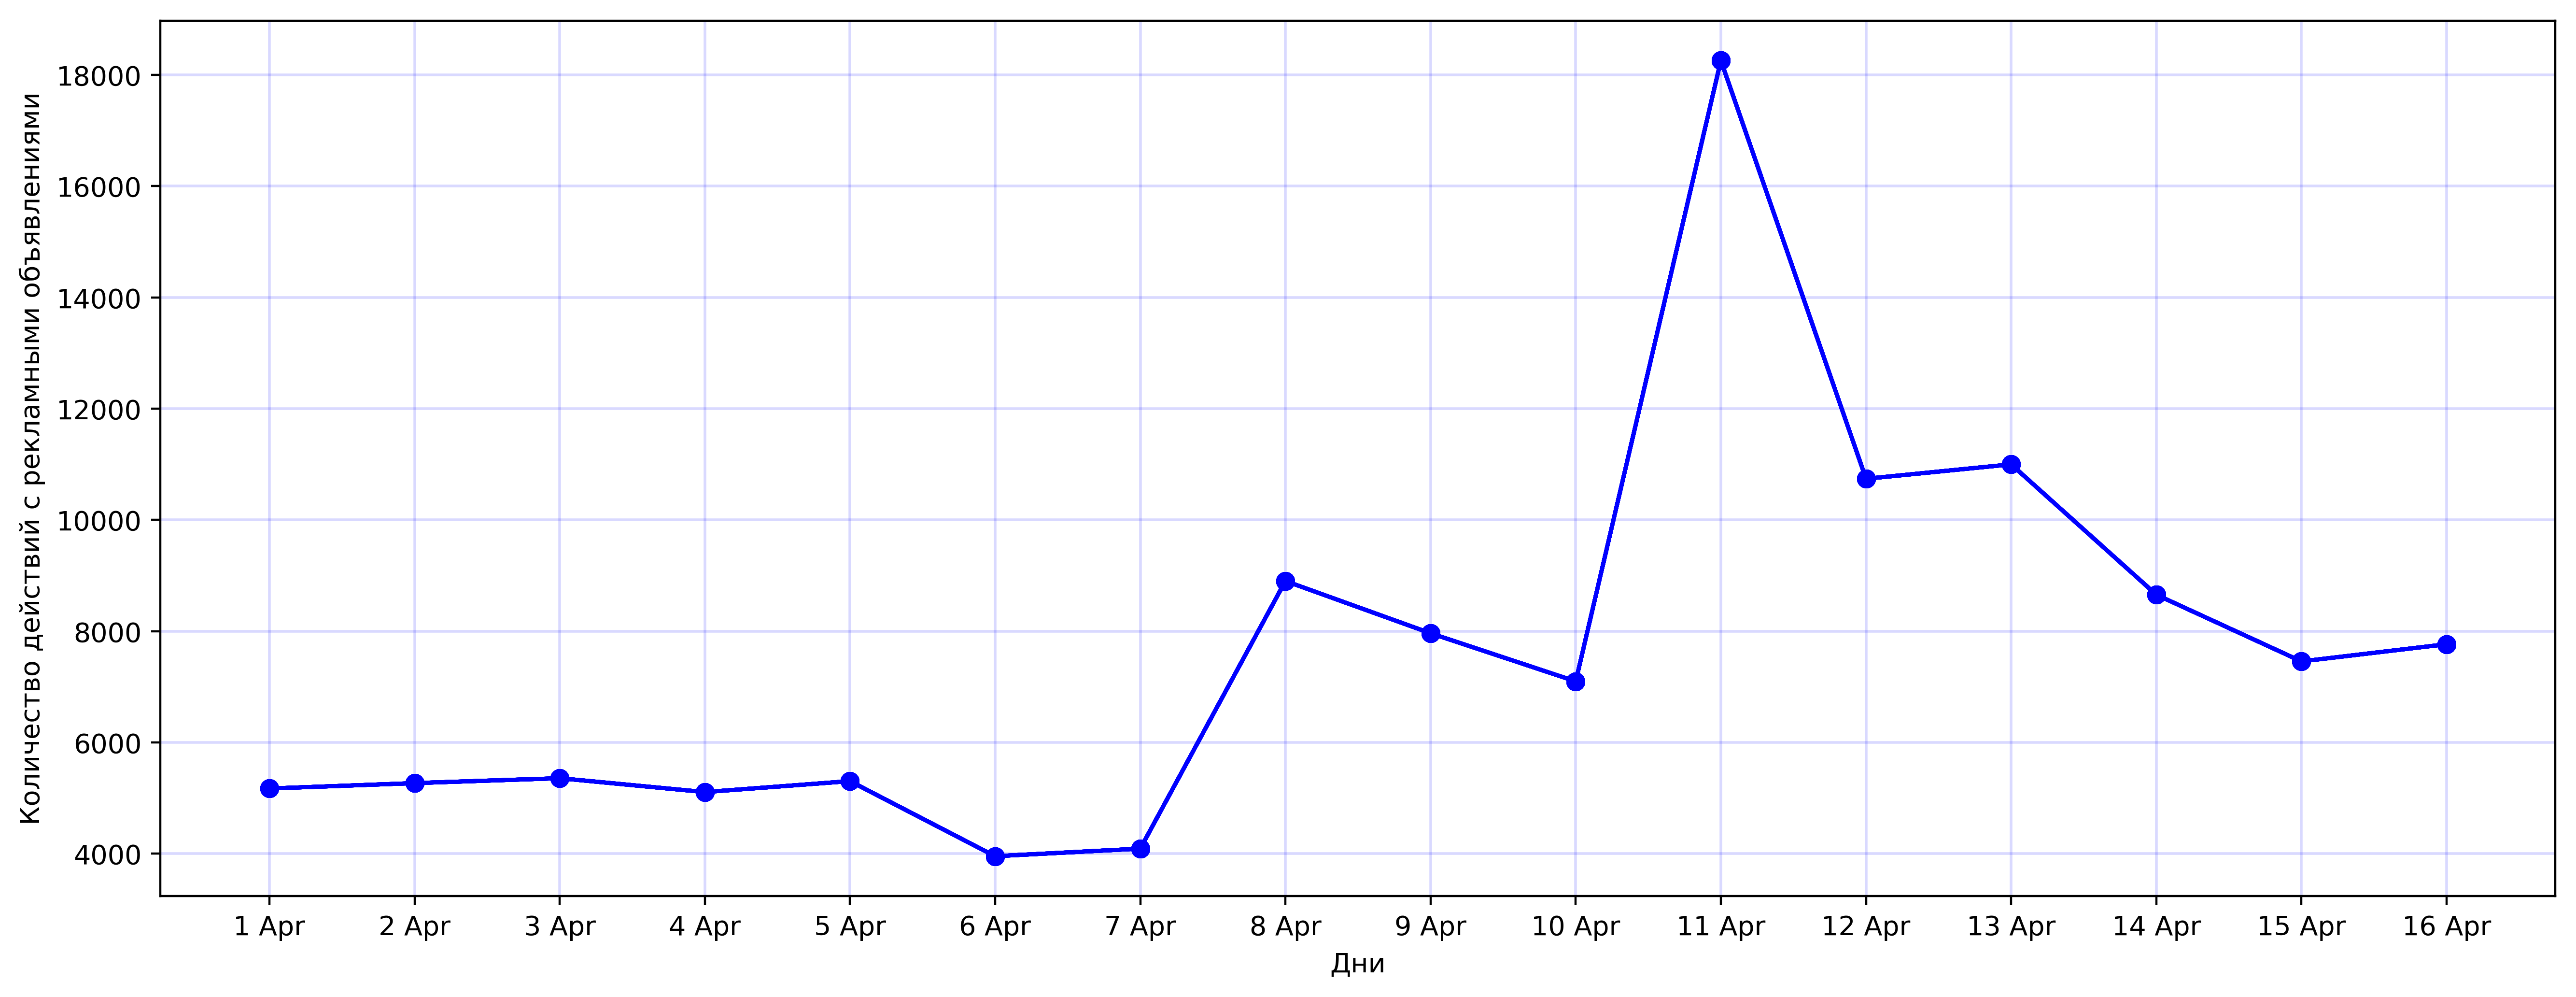

In [3]:
traffic_by_day = data.groupby('date').count()
plt.figure(figsize=(16,6), dpi=400)
plt.grid(color='b', linestyle='-', linewidth=1, alpha=0.15)
plt.plot(traffic_by_day, 'o-b')
plt.xlabel('Дни')
plt.ylabel('Количество действий с рекламными объявлениями')
plt.xticks(range(0, 16), ['{:d} Apr'.format(i) for i in range(1, 17)])
plt.show()

Нарисуем гистограмму количества рекламных взаимодействий по времени:

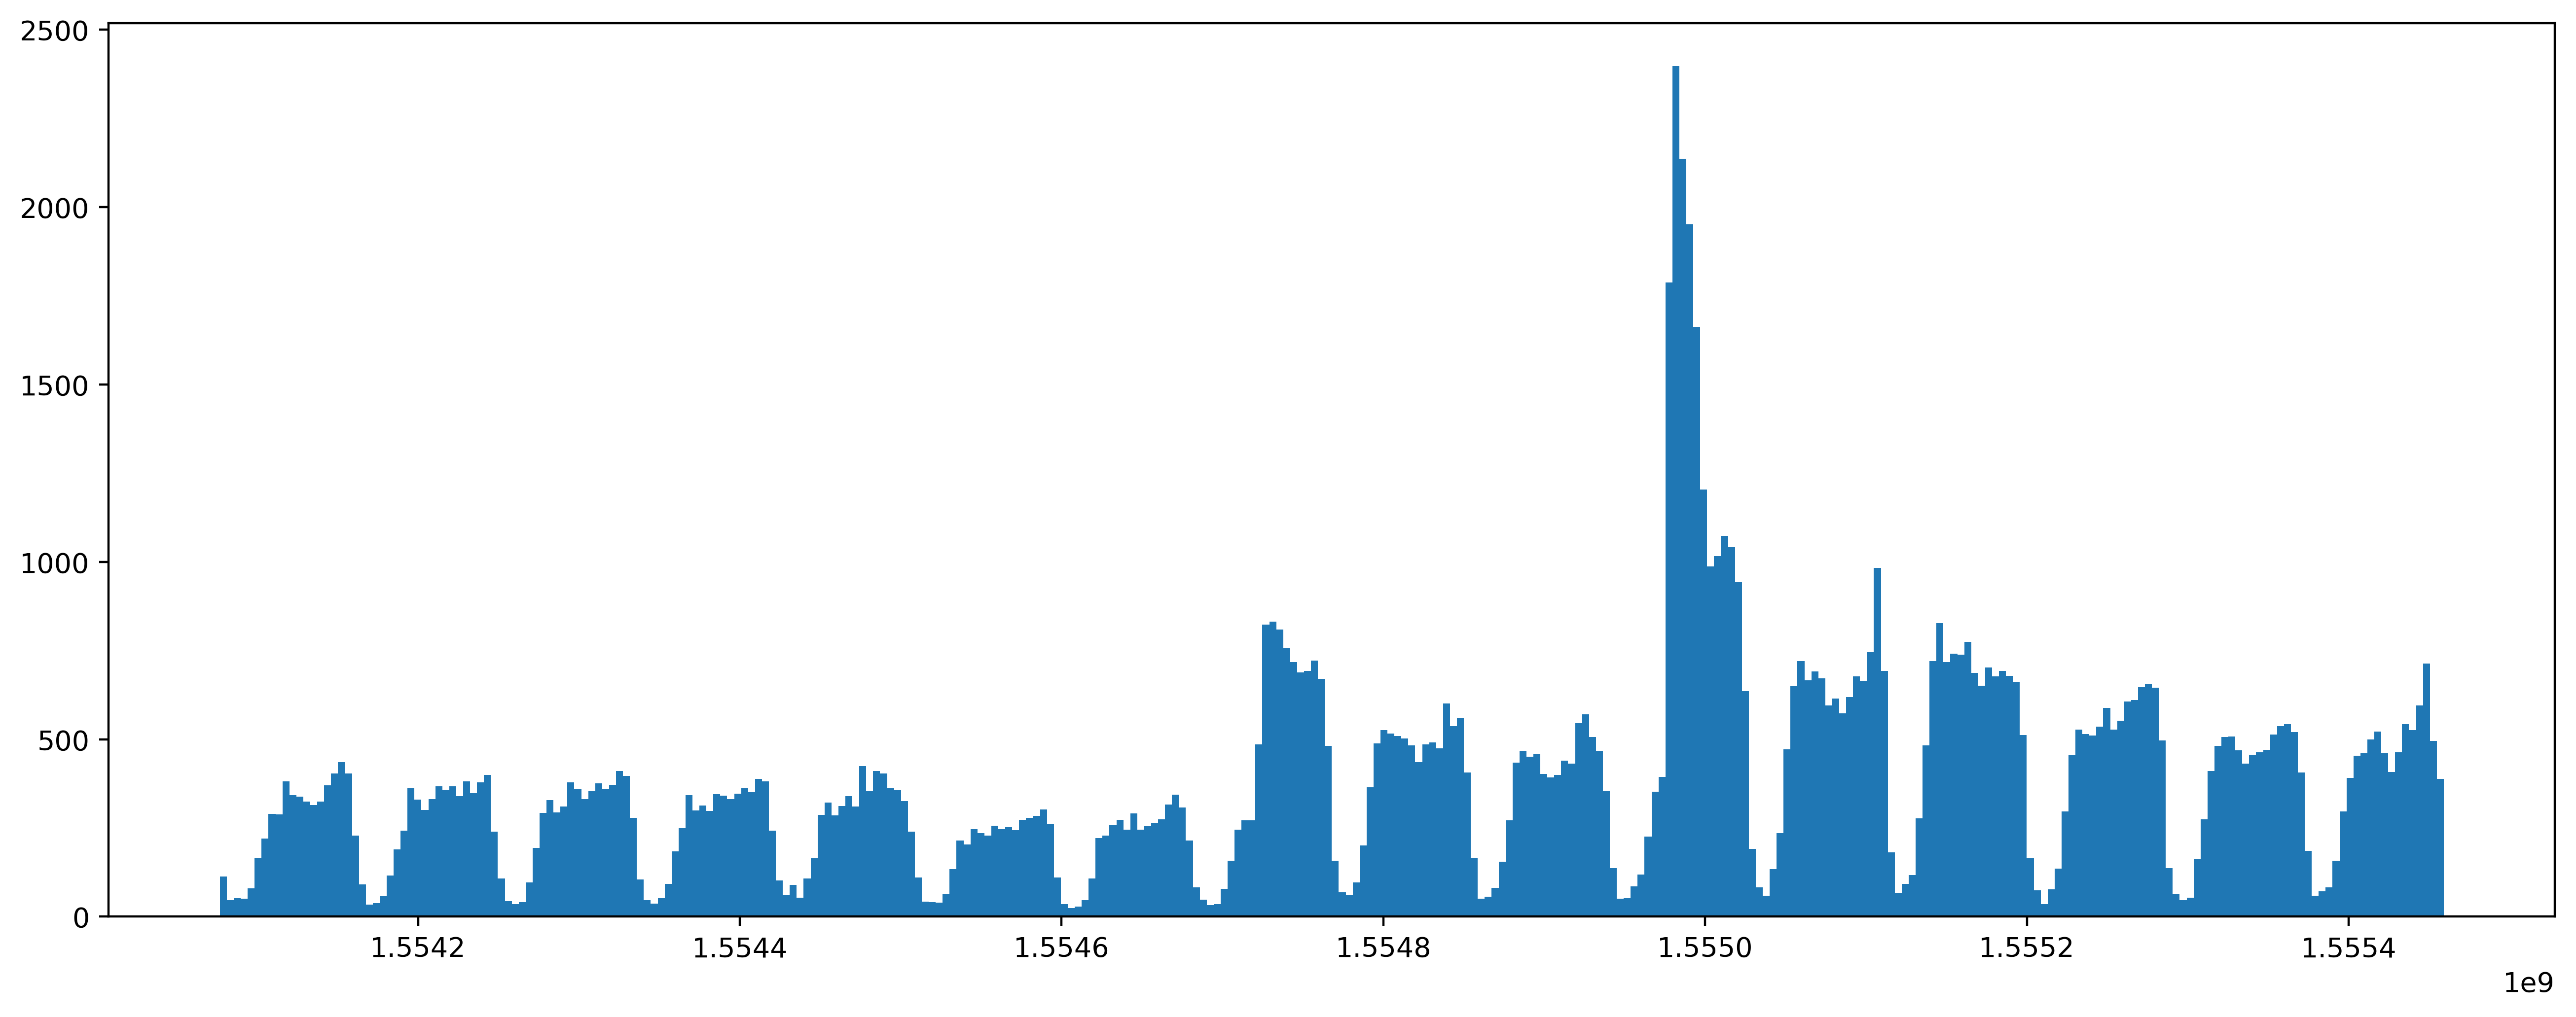

In [4]:
traffic_by_day = data[data['event']=='view'].groupby('date').count()
plt.figure(figsize=(16,6), dpi=400)
plt.hist(data['time'], bins=320)
plt.show()

Найдем объявления, которые показывали 11 апреля чаще всего.  
Уберем из общей статистики топ-4 объявлений за 11 апреля и нарисуем гистограмму снова, аномалий не видно:

Наиболее просматриваемые объявления 11 апреля:
 ad_id
ad_49554     9640
ad_49556     3455
ad_49560      512
ad_49564      334
ad_388        101
ad_47269       79
ad_99303       69
ad_387         42
ad_1181        38
ad_116811      34
Name: time, dtype: int64


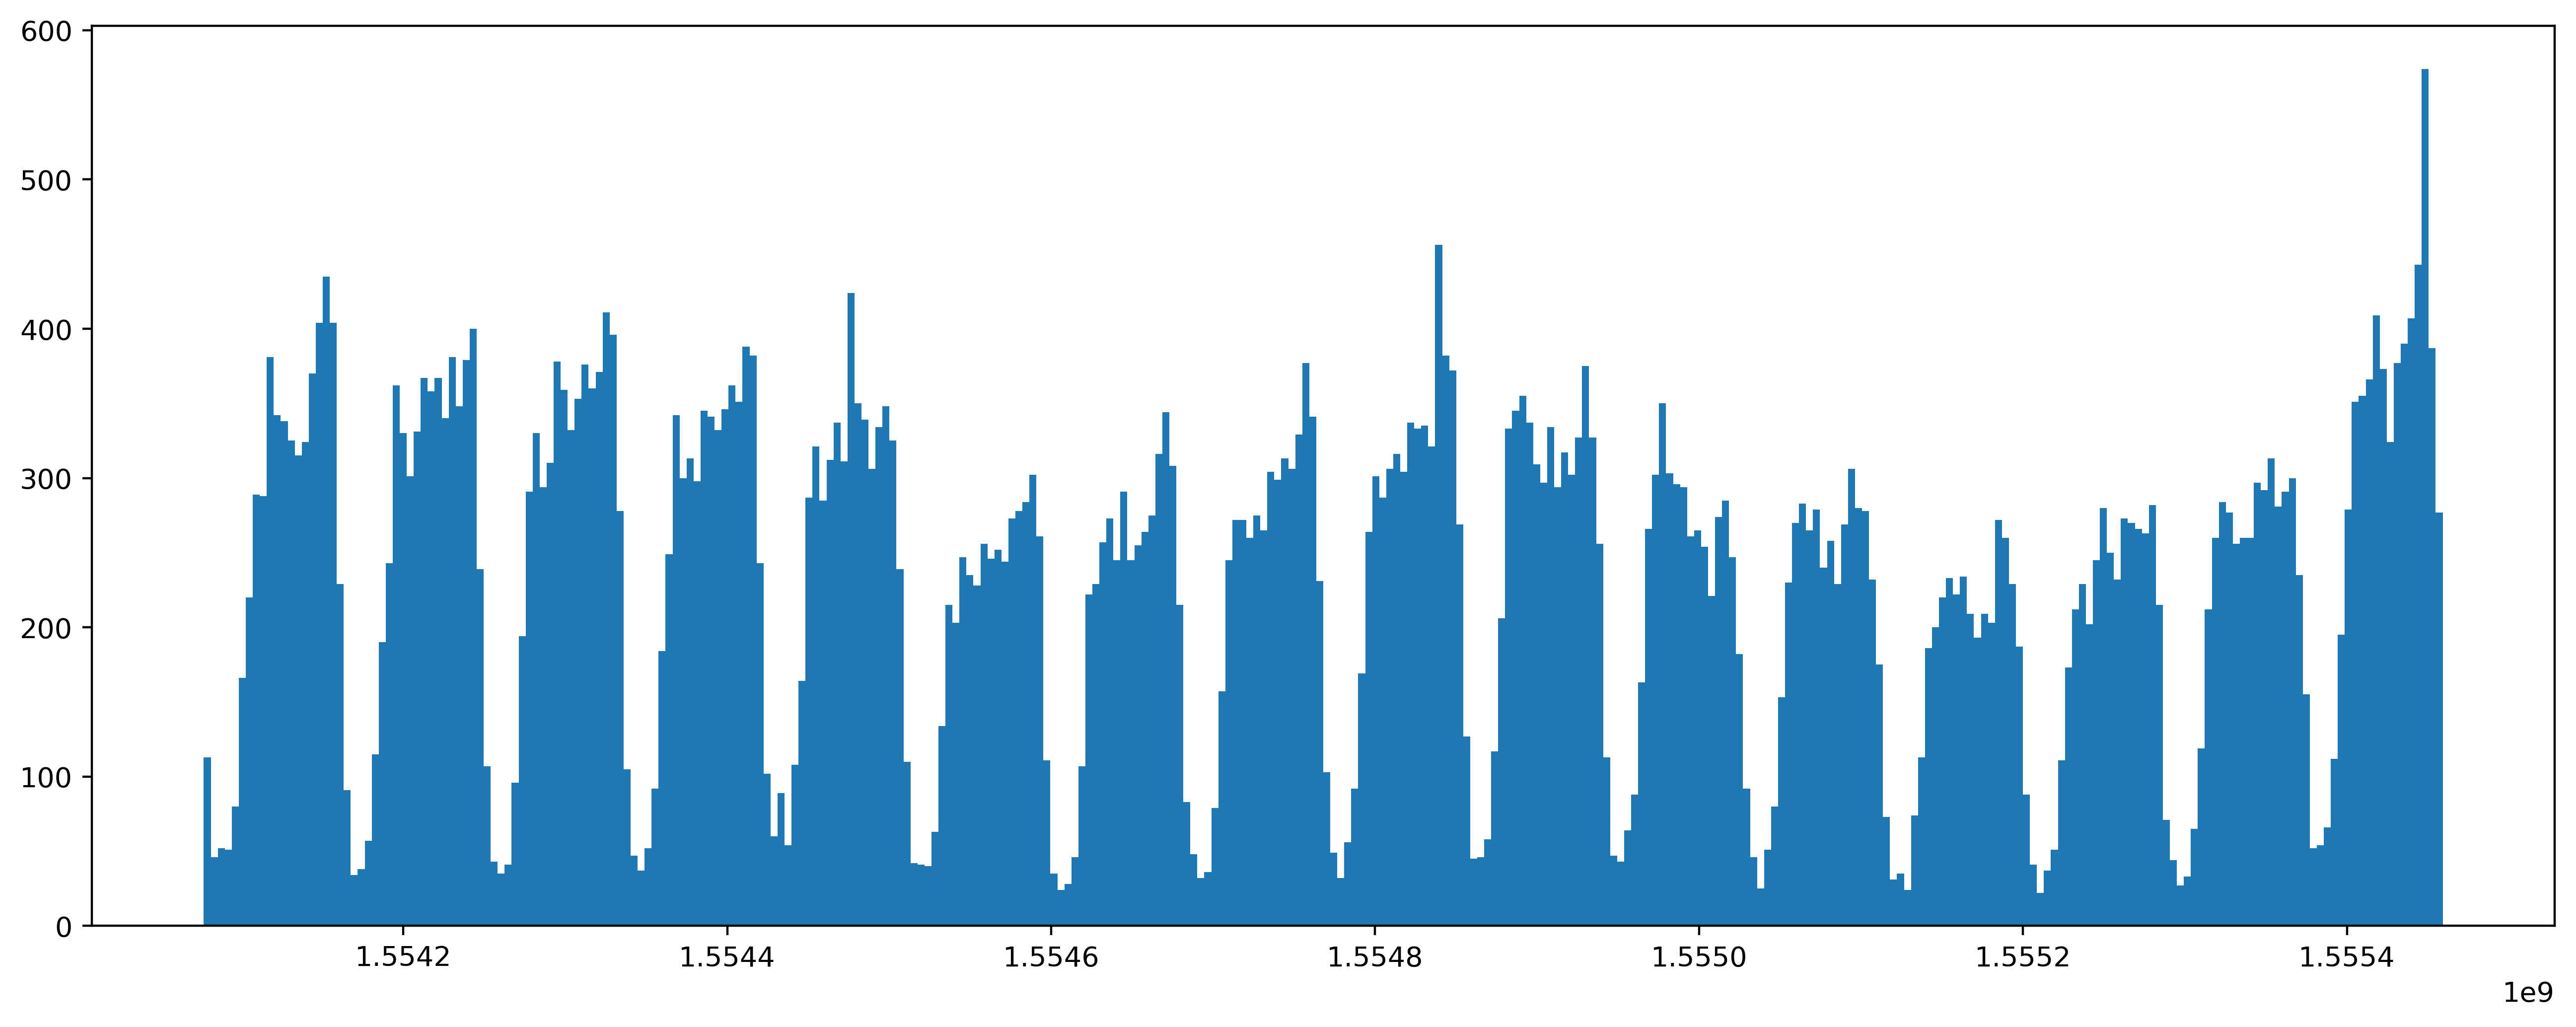

In [5]:
apr11 = data[data['date']=='2019-04-11']
apr11 = apr11.groupby('ad_id').count().sort_values('event', ascending=False)
print('Наиболее просматриваемые объявления 11 апреля:\n', apr11['time'].head(10))
top_ads = apr11.index[:4].values
ad = data[~data['ad_id'].isin(top_ads)]  
plt.figure(figsize=(16,6), dpi=400)
plt.hist(ad['time'], 320)
plt.show()
#print(apr11)

Заметим, что эти четыре объявления принадлежат одной кампании 'campaign_49554', у которой суммарно 5 объявлений:

In [6]:
data[data['campaign_union_id'] == 'campaign_49554'].groupby('ad_id').count().index

Index(['ad_49554', 'ad_49556', 'ad_49560', 'ad_49564', 'ad_50872'], dtype='object', name='ad_id')

Никакой другой интересной информации, связанной с аномалиями 11 апреля, в данных нет.  
Поэтому резкий скачок 11 апреля обусловлен появлением объявлений ad_49554 и ad_49556.  
Так же видно, что из-за создания объявлений ad_49554, ad_49556, ad_49560, ad_49564 количество показов, начиная с 9 апреля увеличилось.  
Почему именно эти объявлений собрали так много просмотров по имеющимся данным сказать нельзя, поскольку в условии задания не было сказано, как именно собиралась/генерировалась статистика и какое поведение является нормальным, а какое - нет.

Если не использовать информацию за предыдущие дни, то можно сделать простой валидатор каждого часа/каждой пятиминутки определенного дня. Достаточно проверять, насколько количество событий за текущий час отличается от среднего количества за предыдущий и следующий час, и если он отличается больше, чем в k раз, то помечать его аномальным:

In [7]:
def find_bad_hours(day, limit):
    t = day.copy()
    t['hour'] = (t['time'] % 86400) // 3600
    t = t.groupby('hour').count()['time'].values
    for i in range(24):
        if (t[i] > limit * (t[i - 1] + t[(i + 1) % 24]) / 2):
            print('{:02d}:00-{:02d}:00 is too active'.format(i, i + 1))
        if (t[i] <  (t[i - 1] + t[(i + 1) % 24]) / 2 / limit):
            print('{:02d}:00-{:02d}:00 is too inactive'.format(i, i + 1))
            
def find_bad_5min(day, limit):
    t = day.copy()
    t['hour'] = (t['time'] % 86400) // 120
    t = t.groupby('hour').count()['time'].values
    for i in range(288):
        if (t[i] > limit * (t[i - 1] + t[(i + 1) % 288]) / 2):
            print('{:02d}:{:02d}-{:02d}:{:02d} is too active'.format(i * 5 // 60, i * 5 % 60, (i + 1) * 5 // 60, (i + 1) * 5 % 60))
        if (t[i] <  (t[i - 1] + t[(i + 1) % 288]) / 2 / limit):
            print('{:02d}:{:02d}-{:02d}:{:02d} is too inactive'.format(i * 5 // 60, i * 5 % 60, (i + 1) * 5 // 60, (i + 1) * 5 % 60))
    
find_bad_hours(data[data['date'] == '2019-04-11'], 2)
find_bad_5min(data[data['date'] == '2019-04-11'], 4)


00:00-01:00 is too inactive
12:35-12:40 is too active
